# Extração de Features e Construção do Modelo

### 1. Introdução a Extração de Features
- A extração de features é uma parte muito importante na análise e na identificação de relações entre diferentes elementos. Como já sabemos, os dados de áudio não podem ser compreendidos diretamente pelos modelos, então precisamos convertê-los para um formato inteligível, e é para isso que a extração de features é utilizada.


#### Com a taxa de amostragem e os dados do sinal, podemos realizar diversas transformações para extrair características valiosas do áudio. No entanto, neste projeto, não vamos aprofundar no processo de seleção de features para identificar quais são mais relevantes para o nosso dataset. Em vez disso, vamos extrair cinco features principais para treinar nosso modelo:
- **Zero Crossing Rate (ZCR):** Mede a taxa de mudanças de sinal no áudio, ou seja, quantas vezes ele cruza o eixo zero em um determinado intervalo de tempo. Essa feature é útil para distinguir sons percussivos e não percussivos.
- **Chroma STFT:** Representa a energia espectral em 12 bins correspondentes às notas da escala musical ocidental. Essa característica é útil para identificar padrões harmônicos no áudio.
- **MFCC (Mel-Frequency Cepstral Coefficients):** Converte a frequência do áudio para a escala mel, aproximando-se da percepção auditiva humana. É uma das features mais utilizadas em reconhecimento de fala e emoção.
- **RMS (Root Mean Square):** Mede a energia do sinal ao calcular a média quadrática das amplitudes do áudio. Essa feature ajuda a representar a intensidade do som.
- **Mel Spectrogram:** Representa a distribuição de energia do áudio em diferentes faixas de frequência na escala mel, capturando informações espectrais essenciais.

### 1.1. Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import soundfile as sf

import pickle
import joblib
import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2025-09-10 18:53:54.646941: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-10 18:53:54.702351: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-10 18:53:56.154294: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


### 1.2. Carregar o Dataframe da EDA 

In [2]:
data_path = "../data/ravdess_preprocessed.csv" 
df = pd.read_csv(data_path)

In [3]:
df

,Emotion,Path,Processed_Path
0,angry,/home/pangsun/Repos/trilhaprojeto02/data/raw/A...,/home/pangsun/Repos/trilhaprojeto02/data/proce...
1,surprise,/home/pangsun/Repos/trilhaprojeto02/data/raw/A...,/home/pangsun/Repos/trilhaprojeto02/data/proce...
2,happy,/home/pangsun/Repos/trilhaprojeto02/data/raw/A...,/home/pangsun/Repos/trilhaprojeto02/data/proce...
3,sad,/home/pangsun/Repos/trilhaprojeto02/data/raw/A...,/home/pangsun/Repos/trilhaprojeto02/data/proce...
4,fear,/home/pangsun/Repos/trilhaprojeto02/data/raw/A...,/home/pangsun/Repos/trilhaprojeto02/data/proce...
...,...,...,...
1435,calm,/home/pangsun/Repos/trilhaprojeto02/data/raw/A...,/home/pangsun/Repos/trilhaprojeto02/data/proce...
1436,fear,/home/pangsun/Repos/trilhaprojeto02/data/raw/A...,/home/pangsun/Repos/trilhaprojeto02/data/proce...
1437,angry,/home/pangsun/Repos/trilhaprojeto02/data/raw/A...,/home/pangsun/Repos/trilhaprojeto02/data/proce...
1438,happy,/home/pangsun/Repos/trilhaprojeto02/data/raw/A...,/home/pangsun/Repos/trilhaprojeto02/data/proce...


### 2. Criando uma função para extração das features

##### Fizemos essa parte no notebook passado, então você pode copiar e colar o código das funções aqui, pois precisaremos delas:

In [4]:
def noise(data):
    # Gere um valor de amplitude de ruído (baseado no valor máximo no dataset) e adicione ruído normal (gaussiano) ao dataset original
    factor = data.max()/40
    return factor*np.random.normal(loc=0.0, scale=1.0, size=data.shape) + data


def stretch(data, rate=0.8):
    # Utilize a função librosa.effects.time_stretch para esticar ou comprimir o áudio pelo fator de taxa especificado.
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    # Determine um valor de deslocamento aleatório dentro de um intervalo e use np.roll para deslocar o dataset.
    return np.roll(data, np.random.randint(-20000,20000))

def pitch(data, sampling_rate, pitch_factor=0.7):
    # Aplique a função librosa.effects.pitch_shift para mudar o pitch do áudio pelo fator especifícado
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# Taking any example and checking for techniques.
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

##### Aqui você deve extrair essas features de fato... mais tarde você precisará delas :)

In [5]:
def extract_features(data, sample_rate):

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(data)
    result = np.array(np.mean(zcr, axis=1))

    # Chroma_stft
    chroma_stft = librosa.feature.chroma_stft(y=data, sr=sample_rate)
    result = np.hstack((result, np.mean(chroma_stft, axis=1)))

    # MFCC
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)
    result = np.hstack((result, np.mean(mfcc, axis=1)))

    # Root Mean Square Value
    rms = librosa.feature.rms(y=data)
    result = np.hstack((result, np.mean(rms, axis=1)))

    # MelSpectrogram
    mel = librosa.feature.melspectrogram(y=data, sr=sample_rate)
    result = np.hstack((result, np.mean(mel, axis=1)))
    
    return result

def get_features(path):
    # Carregar áudio
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    result = []

    # Sem aumento de dados
    res1 = extract_features(data, sample_rate)
    result.append(res1)

    # Com ruído
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result.append(res2)

    # Com alongamento e mudança de pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result.append(res3)
    
    return result

##### Rode as células abaixo

In [6]:
X, Y = [], []
i = 0
for path, emotion in zip(df['Path'], df['Emotion']):
    feature = get_features(path)
    # Appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
    for ele in feature:
        i += 1
        print(f'{100*i/4320:.2f}%', end='\r')
        X.append(ele)
        Y.append(emotion)
print()

100.00%


In [7]:
len(X), len(Y), df.Path.shape

(4320, 4320, (1440,))

In [8]:
Features = pd.concat([pd.DataFrame(X), pd.DataFrame(Y, columns=['labels'])], axis=1)
Features

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.152393,0.448087,0.418845,0.420482,0.307335,0.317016,0.365463,0.430985,0.458315,0.460456,...,0.001223,0.000717,0.000691,0.000783,0.000493,0.000515,0.000439,0.000157,0.000012,angry
1,0.301844,0.590070,0.567521,0.558575,0.481581,0.463825,0.451018,0.474160,0.508429,0.516908,...,0.002699,0.002178,0.002143,0.002246,0.001955,0.001992,0.001926,0.001635,0.001396,angry
2,0.165043,0.385733,0.459305,0.413381,0.368390,0.267160,0.314260,0.343072,0.403269,0.464452,...,0.000205,0.000251,0.000234,0.000109,0.000126,0.000134,0.000079,0.000054,0.000003,angry
3,0.174226,0.451421,0.405392,0.436679,0.555619,0.577351,0.521493,0.459335,0.449024,0.383267,...,0.001644,0.001850,0.000987,0.001558,0.001335,0.001671,0.002068,0.001165,0.000088,surprise
4,0.342448,0.605028,0.599205,0.638157,0.671151,0.702808,0.617530,0.575405,0.572097,0.501261,...,0.003088,0.003286,0.002542,0.003024,0.002801,0.003098,0.003539,0.002633,0.001649,surprise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,0.237332,0.341278,0.320216,0.315268,0.404544,0.428978,0.347182,0.321788,0.405140,0.529855,...,0.002193,0.002406,0.002483,0.002277,0.002202,0.002202,0.002198,0.001958,0.001595,happy
4316,0.179145,0.342470,0.293521,0.246250,0.331803,0.346609,0.265917,0.249905,0.300800,0.440000,...,0.000148,0.000091,0.000165,0.000236,0.000160,0.000140,0.000116,0.000059,0.000006,happy
4317,0.131985,0.296886,0.410592,0.354927,0.439467,0.459705,0.341420,0.275584,0.248546,0.272567,...,0.003395,0.003526,0.003284,0.002161,0.003068,0.001969,0.001727,0.000739,0.000070,surprise
4318,0.265051,0.427226,0.485876,0.503324,0.532507,0.555821,0.452974,0.403519,0.386699,0.419542,...,0.005423,0.005270,0.004907,0.003978,0.005076,0.003924,0.003551,0.002561,0.001867,surprise


##### Agora você deverá salvar o csv de features (features.csv)

In [9]:
# Definir o caminho correto para a pasta 'data' na raiz do projeto
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
os.makedirs(data_dir, exist_ok=True)

# Caminho correto para salvar o CSV na pasta 'data' da raiz do projeto
csv_path = os.path.join(data_dir, "features.csv")

# Crie um DataFrame do pandas chamado Features usando a lista X.
# Adicione uma coluna 'labels' ao DataFrame usando a lista Y.
# Salve o DataFrame como um arquivo CSV no caminho definido, sem incluir o índice, definindo _index_=False
Features.to_csv(path_or_buf=csv_path, index=False)

print(f"O arquivo foi salvo em: {csv_path}")

O arquivo foi salvo em: /home/pangsun/Repos/trilhaprojeto02/data/features.csv


### 2.1. Data Preparation (Preparação dos Dados)

In [10]:
csv_path = '/home/pangsun/Repos/trilhaprojeto02/data/features.csv'
Features = pd.read_csv(csv_path)
Features

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.152393,0.448087,0.418845,0.420482,0.307335,0.317016,0.365463,0.430985,0.458315,0.460456,...,0.001223,0.000717,0.000691,0.000783,0.000493,0.000515,0.000439,0.000157,0.000012,angry
1,0.301844,0.590070,0.567521,0.558575,0.481581,0.463825,0.451018,0.474160,0.508429,0.516908,...,0.002699,0.002178,0.002143,0.002246,0.001955,0.001992,0.001926,0.001635,0.001396,angry
2,0.165043,0.385733,0.459305,0.413381,0.368390,0.267160,0.314260,0.343072,0.403269,0.464452,...,0.000205,0.000251,0.000234,0.000109,0.000126,0.000134,0.000079,0.000054,0.000003,angry
3,0.174226,0.451421,0.405392,0.436679,0.555619,0.577351,0.521493,0.459335,0.449024,0.383267,...,0.001644,0.001850,0.000987,0.001558,0.001335,0.001671,0.002068,0.001165,0.000088,surprise
4,0.342448,0.605028,0.599205,0.638157,0.671151,0.702808,0.617530,0.575405,0.572097,0.501261,...,0.003088,0.003286,0.002542,0.003024,0.002801,0.003098,0.003539,0.002633,0.001649,surprise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,0.237332,0.341278,0.320216,0.315268,0.404544,0.428978,0.347182,0.321788,0.405140,0.529855,...,0.002193,0.002406,0.002483,0.002277,0.002202,0.002202,0.002198,0.001958,0.001595,happy
4316,0.179145,0.342470,0.293521,0.246250,0.331803,0.346609,0.265917,0.249905,0.300800,0.440000,...,0.000148,0.000091,0.000165,0.000236,0.000160,0.000140,0.000116,0.000059,0.000006,happy
4317,0.131985,0.296886,0.410592,0.354927,0.439467,0.459705,0.341420,0.275584,0.248546,0.272567,...,0.003395,0.003526,0.003284,0.002161,0.003068,0.001969,0.001727,0.000739,0.000070,surprise
4318,0.265051,0.427226,0.485876,0.503324,0.532507,0.555821,0.452974,0.403519,0.386699,0.419542,...,0.005423,0.005270,0.004907,0.003978,0.005076,0.003924,0.003551,0.002561,0.001867,surprise


In [11]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [12]:
# Use OneHotEncoder para transformar o Y em uma representação binária categórica, necessária para problemas de classificação multiclasse
Y_2d = Y.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
encoded_Y = encoder.fit_transform(Y_2d)

In [13]:
# Use train_test_split do scikit-learn para dividir X e Y em conjuntos de treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, encoded_Y, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3240, 162), (1080, 162), (3240, 8), (1080, 8))

In [14]:
# Utilize StandardScaler do sklearn para normalizar as características de X
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [15]:
# Rode essa célula para deixar as dimensões certinhas com o modelo que iremos criar.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3240, 162, 1), (1080, 162, 1), (3240, 8), (1080, 8))

### 3. Model Training (Modelling)

#### O modelo que vamos usar é uma rede neural convolucional (CNN) projetada para processar os dados extraídos dos arquivos de áudio. Essa estrutura é ideal para capturar padrões espectrais, como variações de tom e intensidade. A CNN é composta por:
- Camadas Convolucionais (Conv1D): Extraem características do espectro do áudio.
- Camadas de Pooling (MaxPooling1D): Reduzem a dimensionalidade e capturam as informações mais relevantes.
- Dropout: Ajuda a evitar overfitting.
- Camada Flatten: Transforma os mapas de features em um vetor de entrada para a camada totalmente conectada.
- Camadas Densas (Dense): Realizam a classificação final usando a função de ativação softmax.

In [16]:
# Dica: você pode olhar a documentação e ir seguindo o passo a passo arquitetônico para criar o modelo.

# Passo 1: Use Sequential() para criar o modelo como um contêiner linear.
# Passo 2: Adicione uma camada Conv1D com 256 filtros, kernel_size=5, strides=1, padding='same' e função de ativação 'relu'.
# Passo 3: Siga com uma camada MaxPooling1D com pool_size=5, strides=2, padding='same'.
# Passo 4: Adicione mais uma camada Conv1D com 256 filtros, kernel_size=5, strides=1, padding='same' e função de ativação 'relu'.
# Passo 5: Adicione mais uma camada MaxPooling1D com pool_size=5, strides=2, padding='same'.
# Passo 6: Adicione mais uma camada Conv1D com 128 filtros, kernel_size=5, strides=1, padding='same' e função de ativação 'relu'.
# Passo 7: Adicione mais uma camada MaxPooling1D com pool_size=5, strides=2, padding='same'.
# Passo 8: Adicione uma camada Dropout com 0.2 de taxa de dropout.
# Passo 9: Adicione mais uma camada Conv1D com 64 filtros, kernel_size=5, strides=1, padding='same' e função de ativação 'relu'.
# Passo 10: Adicione mais uma camada MaxPooling1D com pool_size=5, strides=2, padding='same'.
# Passo 11: Adicione uma camada Flatten.
# Passo 12: Adicione uma camada Dense com 32 unidades e função de ativação 'relu'.
# Passo 13: Adicione uma camada Dropout com 0.3 de taxa de dropout.
# Passo 14: Adicione uma camada Dense com 8 unidades e função de ativação 'softmax'.
# Passo 15: Compile o modelo com otimizador 'adam', loss 'categorical_crossentropy' e métrica 'accuracy'.
# Passo 16: Use model.summary() para visualizar o modelo.

model = Sequential()
model.add(keras.Input(shape=(162,1)))
model.add(keras.layers.Conv1D(filters=256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(keras.layers.Conv1D(filters=256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=32, activation='relu'))
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(units=8, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


2025-09-10 18:56:56.755253: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

### 3.1. Agora vamos de fato treinar o modelo, siga esses passos: 
##### 1. Use o callback para Ajustar a Taxa de Aprendizado 
##### ReduceLROnPlateau: Diminui a taxa de aprendizado quando uma métrica está estagnada.
   Parâmetros:
   - monitor='loss': Monitora a perda durante o treinamento.
   - factor=0.4: Reduz a taxa de aprendizado por este fator.
   - patience=2: Número de épocas sem melhora antes da redução.
   - min_lr=0.0000001: Limite mínimo para a taxa de aprendizado.
             
##### 2. Treine o Modelo 
##### Utilize model.fit para iniciar o treino da rede neural.
   Parâmetros:
   - x_train, y_train: Conjunto de dados de treino.
   - batch_size=64: Número de amostras por atualização de gradiente.
   - epochs=50: Número de vezes que o modelo treina em todo o conjunto de dados.
   - validation_data=(x_test, y_test): Conjunto de dados para validação durante o treino.
   - callbacks=[rlrp]: Lista de callbacks a serem aplicados durante o treino.
     

In [17]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=1e-7)
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.1904 - loss: 1.9883 - val_accuracy: 0.2241 - val_loss: 1.9402 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.2343 - loss: 1.9308 - val_accuracy: 0.2593 - val_loss: 1.8757 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.2549 - loss: 1.8851 - val_accuracy: 0.2491 - val_loss: 1.8299 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.2682 - loss: 1.8455 - val_accuracy: 0.3056 - val_loss: 1.7521 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.2951 - loss: 1.7846 - val_accuracy: 0.3722 - val_loss: 1.7001 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.3164 - loss: 1.7546 - val_accuracy: 0.3444 - val_loss: 1.6898 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.3410 - loss: 1.7111 -

### 3.2. Avaliar e Visualizar a Performance do Modelo

##### Passo 1: Avaliando o Modelo
- **Precisão nos Dados de Teste**:
  - Use `model.evaluate(x_test, y_test)` para calcular a precisão do modelo no conjunto de teste.

##### Passo 2: Preparando os Gráficos
- **Definindo Épocas**:
  - Crie uma lista de épocas para o eixo x
- **Configurando o Layout do Gráfico**:
  - Use `fig, ax = plt.subplots(1, 2)` para criar dois gráficos lado a lado.

##### Passo 3: Plotando a Perda
- **Gráfico de Perda**:
  - Plote a perda de treino e teste:
    ```python
    ax[0].plot(epochs, train_loss, label='Training Loss')
    ax[0].plot(epochs, test_loss, label='Testing Loss')
    ```

##### Passo 4: Plotando a Precisão
- **Gráfico de Precisão**:
  - Plote a precisão de treino e teste:
    ```python
    ax[1].plot(epochs, train_acc, label='Training Accuracy')
    ax[1].plot(epochs, test_acc, label='Testing Accuracy')
    ```

##### Objetivos:
  - **Perda**: Ajuda a identificar se o modelo está treinando bem ou se há overfitting.
  - **Precisão**: Mostra o quão eficaz é o treinamento do modelo em acertar as previsões.


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6333 - loss: 1.4688


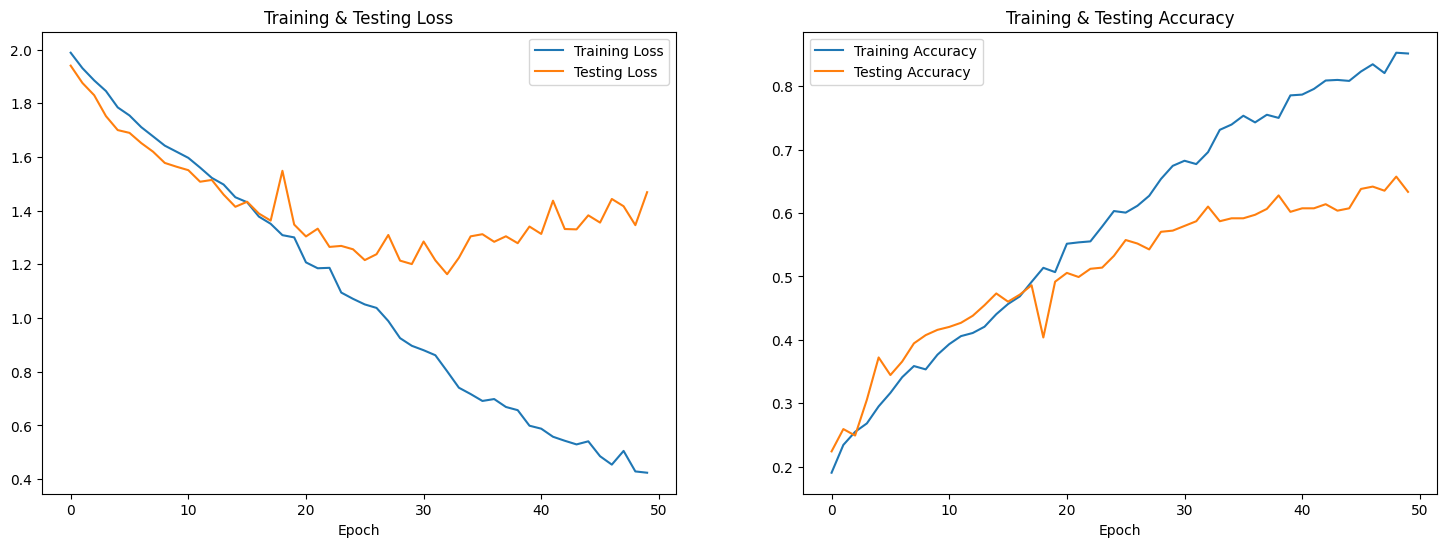

In [18]:
model.evaluate(x_test, y_test)

epochs = history.epoch
train_loss, test_loss = history.history['loss'], history.history['val_loss']
train_acc, test_acc = history.history['accuracy'], history.history['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()

fig.show()

### 3.3. Chegou a parte boa! vamos prever os valores nos dados de teste
- Passo 1: Use model.predict() no x_test e salve o resultado em pred_test.
- Passo 2: Crie y_pred a partir de pred_test usando inverse_transform do encoder (Precisamos converter as previsões codificadas do One-Hot de volta aos rótulos originais)
- Passo 3: Faça o mesmo para os rótulos de teste (y_test), decodificando-os de volta aos rótulos originais.

In [19]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [20]:
# Rode essa célula para ver se o modelo que criamos está fazendo sentido para a maioria dos valores.

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,sad,sad
1,sad,sad
2,fear,happy
3,disgust,disgust
4,calm,calm
5,fear,fear
6,angry,angry
7,neutral,sad
8,fear,surprise
9,neutral,neutral


### 3.4. Plotar Matriz de Confusão
- Agora tenho um desafio para você, eu quero que você crie uma matriz de confusão que relacione os resultados preditos com os valores reais das emoções!

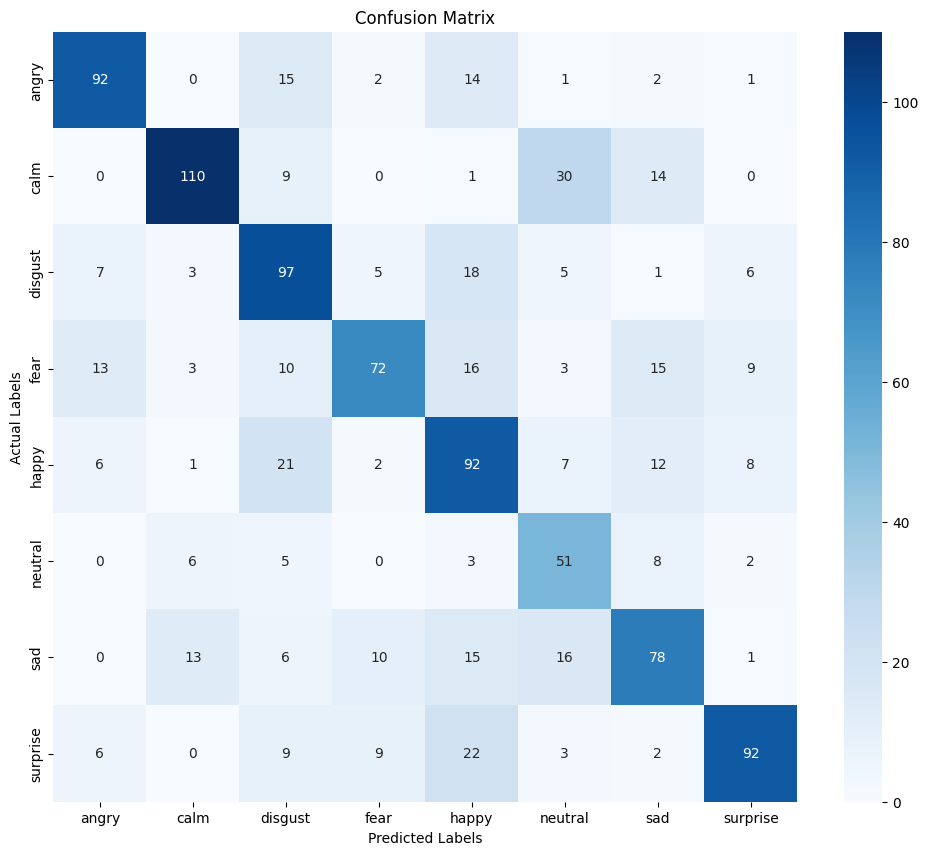

In [21]:
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Use a função classification_report do sklearn para visualizar a precisão, recall e f1-score do modelo.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.74      0.72      0.73       127
        calm       0.81      0.67      0.73       164
     disgust       0.56      0.68      0.62       142
        fear       0.72      0.51      0.60       141
       happy       0.51      0.62      0.56       149
     neutral       0.44      0.68      0.53        75
         sad       0.59      0.56      0.58       139
    surprise       0.77      0.64      0.70       143

    accuracy                           0.63      1080
   macro avg       0.64      0.64      0.63      1080
weighted avg       0.66      0.63      0.64      1080



### 4. Conclusão
- Podemos ver que nosso modelo é mais preciso na predição das emoções surpresa e raiva, o que faz sentido, pois os arquivos de áudio dessas emoções diferem bastante dos outros em aspectos como tom, velocidade, etc.
- No geral, alcançamos 62% de precisão nos dados de teste, o que é razoável, mas podemos melhorar ainda mais aplicando mais técnicas de aumento de dados e utilizando outros métodos de extração de features.

### 5. Salvando o Modelo e o Scaler

##### Passo 1: Salvando o Modelo
1. **Importação:** Use o `load_model` do Keras.
2. **Diretório:** Crie um diretório chamado `models` se não existir.
3. **Salvar:** Salve o modelo como no caminho especificado.

##### Passo 2: Salvando o Scaler
1. **Importação:** Use `joblib`.
2. **Diretório:** Utilize o mesmo caminho `models`.
3. **Salvar:** Salve o scaler.

In [25]:
models_dir = os.path.join(os.path.dirname(os.getcwd()), 'models')
model_path = os.path.join(models_dir, 'audio_emotion_model.keras')
os.makedirs(models_dir, exist_ok=True)
model.save(model_path, overwrite=True)
print(f'Modelo salvo em: {model_path}')

Modelo salvo em: /home/pangsun/Repos/trilhaprojeto02/models/audio_emotion_model.keras


In [24]:
scaler_path = os.path.join(models_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f'Scaler salvo em: {scaler_path}')

Scaler salvo em: /home/pangsun/Repos/trilhaprojeto02/models/scaler.pkl
